<a href="https://colab.research.google.com/github/ksnugroho/feel-in/blob/main/model-baseline-bert/02_BERT_fine_tuning_indobechmark_base_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BERT Fine Tuning: Indobenchmark Base Phase 2 (Uncased)**

**Thesis: Emotion Detection in Indonesian Text**

Kuncahyo Setyo Nugroho<br>
Supervisor:
1. Dr. Eng. Fitra A. Bachtiar, S.T., M.Eng.
2. Prof. Ir. Wayan Firdaus Mahmudy, S.Si., M.T., Ph.D.

Faculty of Computer Science, Brawijaya University, Indonesia &copy; 2021-2022

# 01 Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

In [ ]:
!pip install -q transformers tensorflow-addons

     |████████████████████████████████| 4.4 MB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 65.1 MB/s 
     |████████████████████████████████| 6.6 MB 62.9 MB/s 
     |████████████████████████████████| 596 kB 70.5 MB/s 
     |████████████████████████████████| 101 kB 12.7 MB/s 


In [ ]:
import re
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import cycle
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

import transformers
from transformers import BertTokenizer, BertConfig, TFBertModel

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

SEED = 50

# Tentukan pre-trained model yang akan digunakan untuk fine-tuning
# Daftar model https://huggingface.co

PRE_TRAINED_MODEL = 'indobenchmark/indobert-base-p2'  # https://huggingface.co/indobenchmark/indobert-base-p2
MODEL = PRE_TRAINED_MODEL.replace('/', '-')
FOLDER_PATH = 'model-baseline-bert'

np.random.seed(SEED)
tf.random.set_seed(SEED)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline

In [ ]:
print('Tensorflow:', tf.__version__)
print('Tensorflow addons:',tfa.__version__)
print('Transformers:', transformers.__version__)

Tensorflow: 2.8.2
Tensorflow addons: 0.17.1
Transformers: 4.20.1


In [ ]:
!pip install -q wandb

     |████████████████████████████████| 1.8 MB 4.2 MB/s 
     |████████████████████████████████| 147 kB 77.9 MB/s 
     |████████████████████████████████| 181 kB 78.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login(key='API_KEY')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
TODAY = datetime.datetime.now().strftime("%m-%d-%Y-%H:%M")
print(TODAY)

07-15-2022-15:06


# 02 Load Data

In [ ]:
df = pd.read_csv('data/final-tweet-anotasi.csv', index_col=0)
# df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)   # For shuffle
print(df.head())

                                               tweet    label
0        wah belom liat muka gue lagi murka hahahaha      joy
1  Mungkin kurang piknik adrenalin. Mereka yg ske...    anger
2  maaf kalo tersinggung "orang kurus cepet mati"...    anger
3  berserah pada maha esa paling tabah dan sabar ...      joy
4                       Ehekk malu la hahahahahahaha  sadness


In [ ]:
# df = df.dropna()

In [ ]:
df.shape

(2243, 2)

In [ ]:
# Copy data
df_raw = df.copy()

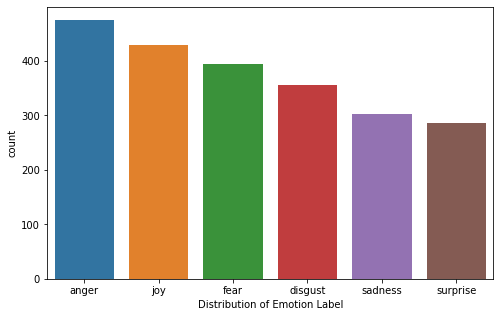

anger       475
disgust     355
fear        395
joy         429
sadness     303
surprise    286
Name: label, dtype: int64

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
plt.xlabel('Distribution of Emotion Label')
plt.show()

df['label'].value_counts().sort_index()

# 03 Preprocessing

## Text Cleaning

In [ ]:
def text_cleaning(text):
    text = text.lower()                               # Mengubah teks menjadi lower case
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
    text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
    text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
    text = text.strip()                               # Menghapus whitespaces
    return text

In [ ]:
%%time 
df['tweet'] = df['tweet'].progress_apply(text_cleaning)

100%|██████████| 2243/2243 [00:00<00:00, 80789.22it/s]

CPU times: user 33.7 ms, sys: 864 µs, total: 34.5 ms
Wall time: 32.9 ms


## Label Encoder

In [ ]:
le = LabelEncoder()

df['label_encode'] = le.fit_transform(df['label'])
print(df.head())

                                               tweet    label  label_encode
0        wah belom liat muka gue lagi murka hahahaha      joy             3
1  mungkin kurang piknik adrenalin mereka yg skep...    anger             0
2  maaf kalo tersinggung orang kurus cepet mati w...    anger             0
3  berserah pada maha esa paling tabah dan sabar ...      joy             3
4                       ehekk malu la hahahahahahaha  sadness             4


In [ ]:
le_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_mapping)

{'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'sadness': 4, 'surprise': 5}


In [ ]:
LABEL_NAME = le.classes_
print(LABEL_NAME)

['anger' 'disgust' 'fear' 'joy' 'sadness' 'surprise']


# 04 Choosing Maximum Lenght of the Sequence

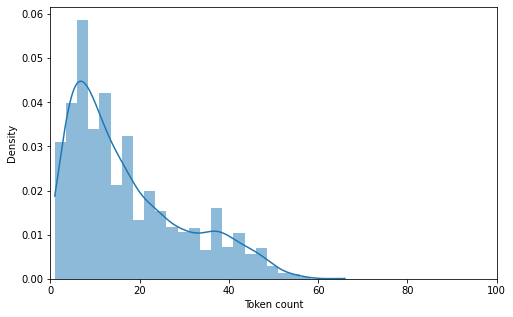

In [ ]:
token_lens = []

for text in df['tweet']:
    tokens = text.split()
    token_lens.append(len(tokens))

plt.figure(figsize=(8, 5))
sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [ ]:
MAX_SEQ_LENGTH = 80

# 05 Train & Test Data Splitting

In [ ]:
NUM_CLASS = len(df['label_encode'].unique())

X = df['tweet']
y = to_categorical(df['label_encode'], num_classes=NUM_CLASS, dtype='float64')  # Lakukan one-hot encoding pada label (y)

In [ ]:
y

array([[0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1794,), (449,), (1794, 6), (449, 6))

# 06 Preparing Data for BERT Input

## Load Pre Trained BERT Tokenizer

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)  # Load tokenizer dari pre-trained model

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

In [ ]:
# Lihat vocabulary dari pre-trained model yang telah di load sebelumnya
vocabulary = bert_tokenizer.get_vocab()

print(vocabulary)
print('Panjang vocabulary:', len(vocabulary))

## BERT Input Formatting

In [ ]:
id_data = 5 # Mengambil sampe data indeks ke-5 pada dataframe

# Contoh input formatting untuk BERT. Input formating dapat menggunakan fungsi `encode_plus`
bert_input = bert_tokenizer.encode_plus(
    df.tweet[id_data],              # Sample kalimat                
    add_special_tokens = True,      # Tambahkan token [CLS] pada awal kalimat dan token [SEP] pada akhir kalimat
    padding = 'max_length',         # Tambahkan padding ke max_length menggunakan token [PAD] jika kalimat kurang dari max_length
    truncation = 'longest_first',   # Truncate jika kalimat lebih dari max_length
    max_length = 50,                # Tentukan max_length dari seluruh kalimat
    return_attention_mask = True,   # Mengembalikan nilai attention mask
    return_token_type_ids =True     # Mengembalikan nilai token type id (segment embedding)
    )

# Fungsi `encode_plus` mengembalikan 3 nilai: input_ids, token_type_ids, attention_mask
bert_input.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
print('Kalimat\t\t:', df_raw.tweet[id_data])                                            # Data asli
print('Tokenizer\t:', bert_tokenizer.convert_ids_to_tokens(bert_input['input_ids']))    # Hasil input formatting + tokenizer
print('Input IDs\t:', bert_input['input_ids'])                                          # Input IDs : indeks token pada vocabulary tokenizer
print('Token Type IDs\t:', bert_input['token_type_ids'])                                # Token type IDs : menunjukkan urutan kalimat pada sequence (segment embedding)
print('Attention Mask\t:', bert_input['attention_mask'])                                # Attention mask : mengembalikan nilai [0,1]. 1 artinya token yang di masking, 0 token yang tidak di masking (diabaikan)

Kalimat		: WKWKWKWK KESAL AKU BACANYA TAPI KOK SENYUM2
Tokenizer	: ['[CLS]', 'wkwkwk', '##w', '##k', 'kesal', 'aku', 'baca', '##nya', 'tapi', 'kok', 'senyum', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Input IDs	: [2, 19720, 30374, 30361, 10531, 304, 2064, 57, 469, 2105, 7319, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Token Type IDs	: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention Mask	: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# Buat fungsi untuk melakukan encode pada semua data
def tokenize(data):
    input_ids = []
    attention_masks = []
    
    for i, text in tqdm(enumerate(data)):
        tokens = bert_tokenizer.encode_plus(
            text, 
            max_length=MAX_SEQ_LENGTH,
            truncation='longest_first',
            padding='max_length',
            add_special_tokens=True, 
            return_attention_mask=True,
            return_token_type_ids=False, 
            return_tensors='tf'
          )   
         
        input_ids.append(np.asarray(tokens['input_ids']).reshape(MAX_SEQ_LENGTH,))
        attention_masks.append(np.asarray(tokens['attention_mask']).reshape(MAX_SEQ_LENGTH,))

    return (np.asarray(input_ids), np.asarray(attention_masks))

In [ ]:
train_input_ids, train_attention_masks = tokenize(X_train)
test_input_ids, test_attention_masks = tokenize(X_test)

1794it [00:01, 1000.84it/s]
449it [00:00, 1057.35it/s]


In [ ]:
train_input_ids.shape, train_attention_masks.shape, test_input_ids.shape, test_attention_masks.shape

((1794, 80), (1794, 80), (449, 80), (449, 80))

# 07 Define Model (BERT)

## Load Pre-Trained BERT Model

In [ ]:
bert_config = BertConfig.from_pretrained(PRE_TRAINED_MODEL, output_hidden_states=True, num_labels=NUM_CLASS)
bert = TFBertModel.from_pretrained(PRE_TRAINED_MODEL, config=bert_config)
bert.summary()

Downloading:   0%|          | 0.00/625M [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  124441344 
                                                                 
Total params: 124,441,344
Trainable params: 124,441,344
Non-trainable params: 0
_________________________________________________________________


## Architecture

In [ ]:
tf.keras.backend.clear_session()

# Defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), name='input_ids', dtype='int32')
attn_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), name='attention_mask', dtype='int32')

# We access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
# Access final activations (alread max-pooled) [1] 0 -> activation layer (3D), 1 -> pooled output layer (2D)
bert_embedding = bert(input_ids, attention_mask=attn_mask)[1]  

x = tf.keras.layers.Dense(512, activation='relu')(bert_embedding)
x = tf.keras.layers.Dropout(0.5)(x)
output_layer = tf.keras.layers.Dense(NUM_CLASS, activation='softmax', name='output_layer')(x)

# Initialize model
model = tf.keras.Model(inputs=[input_ids, attn_mask], outputs=output_layer)

# Trainable=False to freeze bert layer for feature extraction (optional)
model.layers[2].trainable = True

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 80)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 80)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  124441344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 80,                                            

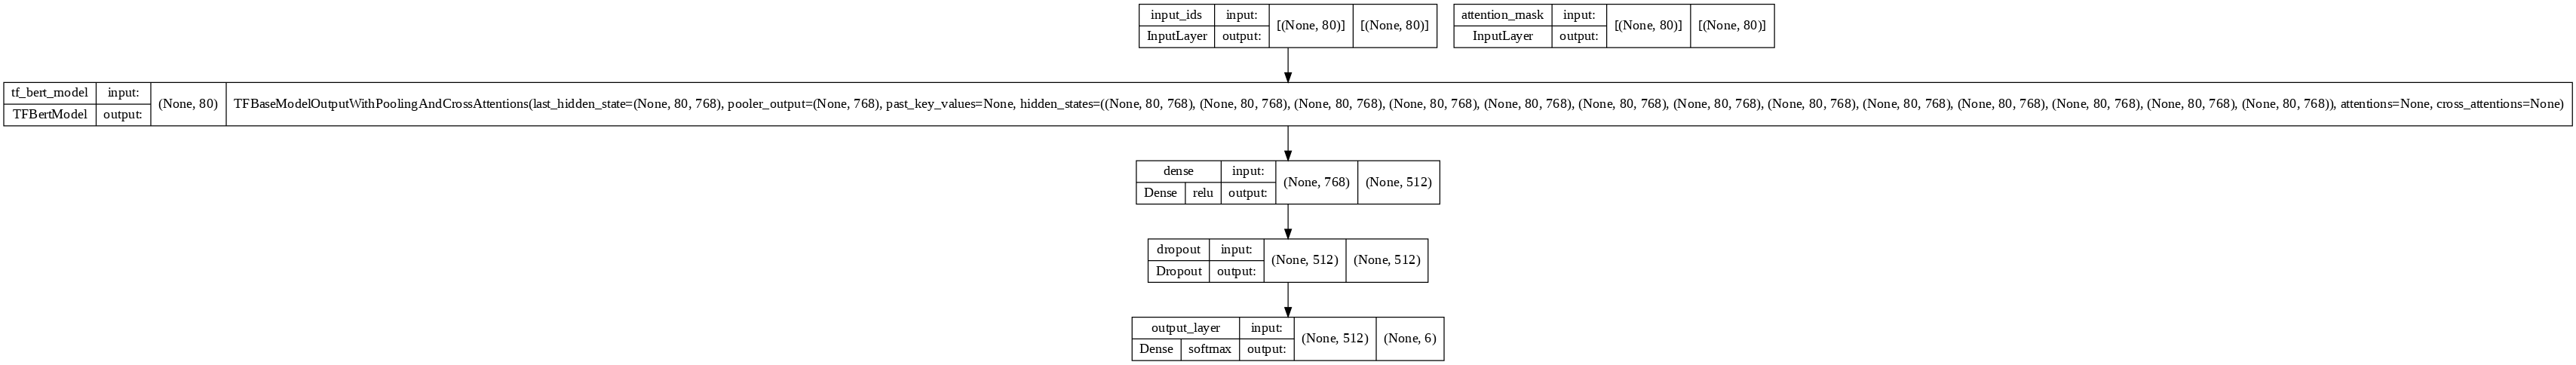

In [ ]:
plot_model(model, show_shapes=True, show_layer_activations=True, show_dtype=False, dpi=90, to_file=f'{FOLDER_PATH}/model-plot/{MODEL}-model.png')

## Compile

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics

METRICS = [
           tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
]

LEARNING_RATE = 2e-5 # Recommended learning rate (AdamW): [5e-5, 3e-5, 2e-5] in orginal paper

In [ ]:
OPTIMIZER = AdamW(learning_rate=LEARNING_RATE, beta_1=0.8, beta_2=0.9, weight_decay=0.0001)
LOSS_FUNCTION = CategoricalCrossentropy(name='categorical_crossentropy')

model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=METRICS)

# 08 Early Stopping & Model Checkpoint

In [ ]:
# Early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=5)

# Path to model checkpoint
checkpoint_dir = f'{FOLDER_PATH}/model-checkpoint/{MODEL}/cp.ckpt'
model_checkpoint = ModelCheckpoint(checkpoint_dir, monitor='val_accuracy', save_weights_only=True, verbose=1, save_freq='epoch', save_best_only=True)

In [ ]:
# Path to model log
log_dir = f'{FOLDER_PATH}/model-log/{MODEL}/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
print(log_dir)

model-baseline-bert/model-log/indobenchmark-indobert-base-p2/20220715-150742


Tensorflow Callback

In [ ]:
tensorboard_callback = TensorBoard(log_dir=log_dir ,update_freq='epoch', histogram_freq=1, embeddings_freq=1)

# 09 Training (Fine-Tuning)

In [ ]:
EPOCHS = 4        # Recommended number of epochs: [2, 3, 4] in orginal paper
BATCH_SIZE = 32   # Recommended batch size: [16, 32] in orginal paper

# Config for wandb
config = {
    'type': 'baseline',
    'model_architecture': 'BERT',
    'dataset': 'indo-tweet-emotion',
    'learning_rate': LEARNING_RATE,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
    'loss_function': LOSS_FUNCTION.name,
    'optimizer': OPTIMIZER._name
}

In [ ]:
%%time

# Initialize wandb 
wandb.tensorboard.patch(root_logdir=log_dir)
wandb_run = wandb.init(project='baseline-bert', name=f'{MODEL}', entity='indoemobert', config=config, sync_tensorboard=True)

# Training
model_history = model.fit(
    (train_input_ids, train_attention_masks),
    y_train,
    validation_data=((test_input_ids, test_attention_masks), y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    steps_per_epoch=int(np.ceil(X_train.shape[0] / BATCH_SIZE)),
    callbacks=[
      # early_stopping, 
      # model_checkpoint,
      # tensorboard_callback,
      WandbCallback(
          input_type='text',
          training_data=((train_input_ids, train_attention_masks), y_train),
          validation_data=((test_input_ids, test_attention_masks), y_test),
          labels=LABEL_NAME,
          monitor='val_loss',
          log_best_prefix='best_',
          log_gradients=True,
          log_weights=True,
          save_weights_only=True,
          save_model=False
      )]
)

wandb_run.finish()

wandb: Currently logged in as: indoemobert. Use `wandb login --relogin` to force relogin


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/4
57/57 [==============================] - 140s 2s/step - loss: 1.4940 - accuracy: 0.4342 - precision: 0.7434 - recall: 0.1873 - val_loss: 0.5696 - val_accuracy: 0.8463 - val_precision: 0.8782 - val_recall: 0.7550 - _timestamp: 1657897821.0000 - _runtime: 159.0000
Epoch 2/4
57/57 [==============================] - 94s 2s/step - loss: 0.6179 - accuracy: 0.8138 - precision: 0.8437 - recall: 0.7670 - val_loss: 0.5091 - val_accuracy: 0.8441 - val_precision: 0.8601 - val_recall: 0.8218 - _timestamp: 1657897915.0000 - _runtime: 253.0000
Epoch 3/4
57/57 [==============================] - 95s 2s/step - loss: 0.4805 - accuracy: 0.8567 - precision: 0.8798 - recall: 0.8322 - val_loss: 0.5270 - val_accuracy: 0.8463 - val_precision: 0.8565 - val_recall: 0.8374 - _timestamp: 1657898010.0000 - _runtime: 348.0000
Epoch 4/4
57/57 [==============================] - 95s 2s/step - loss: 0.3585 - accuracy: 0.88

accuracy,▁▇██
epoch,▁▃▆█
loss,█▃▂▁
precision,▁▅▇█
recall,▁▇██
val_accuracy,███▁
val_loss,▅▁▂█
val_precision,█▆▅▁
val_recall,▁▇█▅
GFLOPS,6.93038
accuracy,0.88629


CPU times: user 5min 41s, sys: 43 s, total: 6min 24s
Wall time: 7min 28s


In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  plt.figure(figsize=(12, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace('_',' ').capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle='--', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend(loc='lower right');

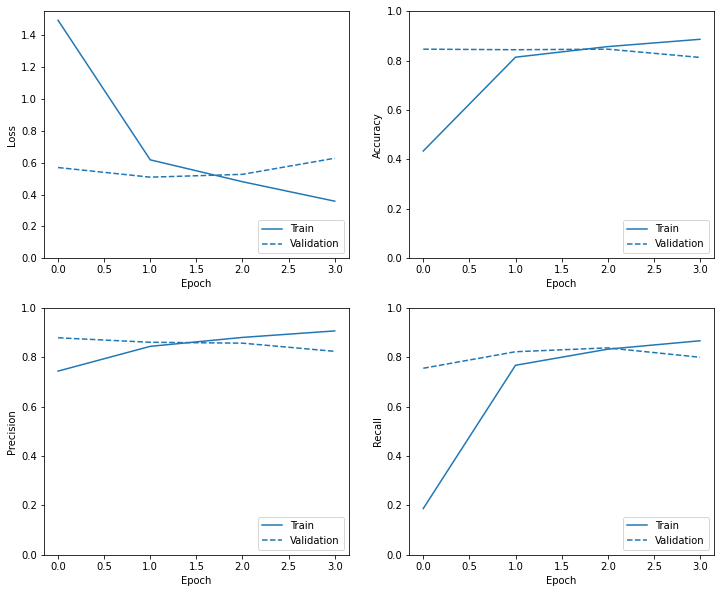

In [ ]:
plot_metrics(model_history)

In [ ]:
hist_df = pd.DataFrame(model_history.history)
print(hist_df)

hist_df.to_csv(f'{FOLDER_PATH}/model-history/{MODEL}-{TODAY}.csv')

       loss  accuracy  precision    recall  val_loss  val_accuracy  \
0  1.494022  0.434225   0.743363  0.187291  0.569577      0.846325   
1  0.617861  0.813824   0.843654  0.767001  0.509138      0.844098   
2  0.480550  0.856745   0.879788  0.832219  0.526967      0.846325   
3  0.358474  0.886288   0.906122  0.866221  0.627944      0.812918   

   val_precision  val_recall  _timestamp  _runtime  
0       0.878238    0.755011  1657897821       159  
1       0.860140    0.821826  1657897915       253  
2       0.856492    0.837416  1657898010       348  
3       0.823394    0.799555  1657898105       443  


In [ ]:
# save model
# model.save(f'{FOLDER_PATH}/model-fit/{MODEL}/{MODEL}.h5')

# 10 Evaluation

In [ ]:
y_pred = np.argmax(model.predict((test_input_ids, test_attention_masks)), axis=1)
y_true = np.argmax(y_test, axis=1)

loss, accuracy, precision, recall = model.evaluate((test_input_ids, test_attention_masks), y_test)
print("Accuracy: %.2f%%" % (accuracy*100))

15/15 [==============================] - 2s 158ms/step - loss: 0.6279 - accuracy: 0.8129 - precision: 0.8234 - recall: 0.7996
Accuracy: 81.29%


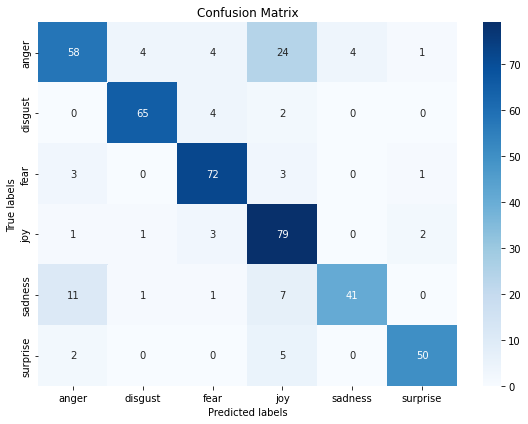

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')  # annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(LABEL_NAME)
ax.yaxis.set_ticklabels(LABEL_NAME)
plt.tight_layout()

In [ ]:
print(classification_report(y_pred, y_true, target_names=LABEL_NAME))

              precision    recall  f1-score   support

       anger       0.61      0.77      0.68        75
     disgust       0.92      0.92      0.92        71
        fear       0.91      0.86      0.88        84
         joy       0.92      0.66      0.77       120
     sadness       0.67      0.91      0.77        45
    surprise       0.88      0.93      0.90        54

    accuracy                           0.81       449
   macro avg       0.82      0.84      0.82       449
weighted avg       0.84      0.81      0.81       449



In [ ]:
def plot_roc_curve(y_test, y_pred):
  
  n_classes = len(np.unique(y_test))
  y_test = label_binarize(y_test, classes=np.arange(len(LABEL_NAME)))
  y_pred = label_binarize(y_pred, classes=np.arange(len(LABEL_NAME)))

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  
  # Compute micro-average ROC curve and ROC area
  fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

  # Plot all ROC curves
  plt.figure(figsize=(10, 7))
  lw = 2
  plt.plot(fpr['micro'], tpr['micro'],
    label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['micro']),
    color='deeppink', linestyle=':', linewidth=4,)

  plt.plot(fpr['macro'], tpr['macro'],
    label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
    color='navy', linestyle=':', linewidth=4,)

  colors = cycle(['aqua', 'darkorange', 'darkgreen', 'yellow', 'blue', 'red'])
  for i, color, label in zip(range(n_classes), colors, LABEL_NAME):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(label, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) curve')
  plt.legend()
  plt.show()

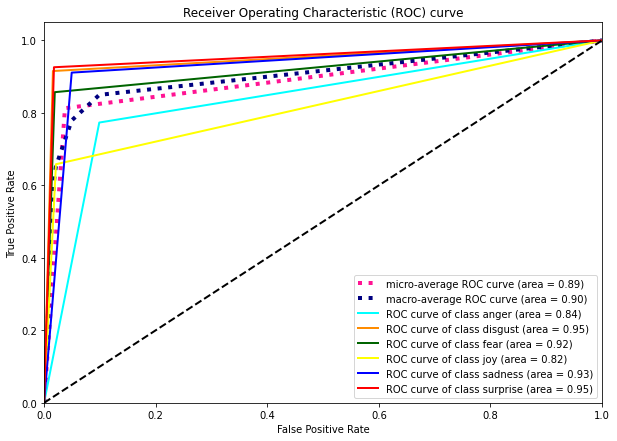

In [ ]:
plot_roc_curve(y_pred, y_true)

# 11 Predict on New Data

In [ ]:
# Sample text
input_text = 'Hargai kebahagiaan jika kamu pernah sedih'

def prep_data(text):
    tokens = bert_tokenizer.encode_plus(
        text, 
        max_length=MAX_SEQ_LENGTH,
        truncation=True, 
        padding='max_length',
        add_special_tokens=True, 
        return_token_type_ids=False,
        return_tensors='tf'
      )
    
    # Tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64), 'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [ ]:
pred = model.predict(prep_data(input_text))
print(pred, LABEL_NAME[np.argmax(pred, axis=1)])

[[9.0729203e-03 7.2504696e-04 3.4014757e-03 9.1634911e-01 6.7302510e-02
  3.1490219e-03]] ['joy']
